In [3]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import glob
import pickle
import random
from scipy.stats import hmean
import re
from bs4 import BeautifulSoup
import requests
from sklearn.metrics.pairwise import cosine_similarity
import sys

In [4]:
nlp = spacy.load('en_core_web_trf')
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

In [5]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [6]:
%matplotlib inline

## CUB preprocessing

In [11]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()
    
# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]

In [12]:
# Open the text file
location = "../data/external/CUB_200_2011/attributes.txt"
with open(location) as f:
    lines = f.readlines()
    
attribute_list = []

# Create a DF with attributes
for line in lines:
    line = line.strip()
    attributes = line.split()[1].split('::')
    part = attributes[0]
    adjective = attributes[1]
    attribute_list.append((part, adjective))
    
# Create DF        
df_attributes = pd.DataFrame(attribute_list, columns=['Part', 'Adj'])
# Reset the index
df_attributes.index = np.arange(1, len(df_attributes)+1)

In [13]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt"
with open(location) as f:
    lines = f.readlines()
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/images.txt"
with open(location) as f:
    img_ids = f.readlines()
    
# Create DF will all present parts
CUB_dict = collections.defaultdict(list)
# Loop over lines
for line in tqdm_notebook(lines):
    data = line.split()
    # Skip non present
    if not int(data[2]):
        continue
    # Skip uncertain things
    if int(data[3]) < 4:
        continue
    # Otherwise append
    #print(CUB[int(img_ids[int(data[0])].split()[1][0:3]) - 1], data)
    CUB_dict[CUB[int(img_ids[int(data[0])-1].split()[1][0:3]) - 1]].append((df_attributes.loc[int(data[1]), ][0], df_attributes.loc[int(data[1]), ][1]))

  0%|          | 0/3677856 [00:00<?, ?it/s]

### Open BOW matched text file
Open the BOW matched text file and reqrite the CUB dataset to match the BOW set

In [14]:
# Open the text file
location = "../data/external/birds_matched.txt"
with open(location) as f:
    lines = f.readlines()

BOW_list = []
for line in lines[1:]:
    line = line.strip()
    _, CUB, BOW = line.split(';')
    BOW_list.append((CUB, BOW))    

In [15]:
# Rewrite the CUB dict
CUB_dict_new = collections.defaultdict(list)

for (CUB, BOW) in BOW_list:
    CUB_dict_new[BOW] = CUB_dict[CUB]

# Attribution

In [16]:
# birds descriptions
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))
# trained model
model = load_CUB_Bert("../models/", 'saved_weights_CUB_BIRDS_2000.pt', outputsize=2000)

Local Success


### Helper functions

In [17]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# Modify the prediction output and define a custom forward
def predict(inputs, attentions):
    return model(input_ids=inputs, attention_mask=attentions)[0]

def custom_forward(inputs, attentions):
    preds = predict(inputs, attentions)
    return torch.exp(preds)

# Tokenize functions
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

# Summarize and vis functions
def summarize_attributions_ig(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def summarize_attributions_occ(attributions):
    return attributions.sum(axis=0)

def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

def colorize(attribution, tokens):
    
    template = """  
    <mark class="entity" style=" background: {}; padding: 0.4em 0.0em; margin: 0.0em; line-height: 2; 
    border-radius: 0.0em; ">{}<span style=" font-size: 0.8em;  font-weight: bold;  line-height: 1; 
    border-radius: 0.0em; text-align-last:center; vertical-align: middle; margin-left: 0rem; "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.Greens).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]': 
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

def explain(word):
    
    data = collections.defaultdict(list)
       
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(word, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    #### Layer IG 20 steps
    attribution_ig = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=20,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attributions_ig_sum = summarize_attributions_ig(attribution_ig)
    attributions_ig_words, words = token_to_words(attributions_ig_sum, all_tokens)
    data['Words'] = words
    data['IG_20'] = attributions_ig_words
    ####
    
    #### Layer IG 100 steps
    attribution_ig_100 = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=50,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attribution_ig_100_sum = summarize_attributions_ig(attribution_ig_100)
    attributions_ig_100_words, _ = token_to_words(attribution_ig_100_sum, all_tokens)
    #print(attribution_ig_100_sum)
    data['IG_50'] = attributions_ig_100_words
    ####
    
    ### Occlusion maps 
    attribution_occ = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([1,]), tuple([1,])), 
                                baselines=(ref_input_ids, attention_mask),)
    attributions_occ_sum = summarize_attributions_occ(attribution_occ[0])
    attributions_occ_words, _ = token_to_words(attributions_occ_sum, all_tokens)
    data['Occ_1-1'] = attributions_occ_words
    #### Occlusion maps (3, 2)
    attribution_occ2 = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([3,]), tuple([3,])), 
                                strides=(2, 2), 
                                baselines=(ref_input_ids, attention_mask),)
    attribution_occ2_sum = summarize_attributions_occ(attribution_occ2[0])
    attributions_occ2_words, _ = token_to_words(attribution_occ2_sum, all_tokens)
    data['Occ_3-2'] = attributions_occ2_words
    ####
    
    #### Shapley Value Sampling
    attribution_SVS = SVS.attribute(inputs=(input_ids, attention_mask),
                                baselines=(ref_input_ids, attention_mask),
                                   n_samples=5)
    attributions_SVS_sum = attribution_SVS[0][0]
    attributions_SVS_words, _ = token_to_words(attributions_SVS_sum, all_tokens)
    data['SVS'] = attributions_SVS_words
    ####
    
    ### Layer Activation
    attribution_la = la.attribute(inputs=(input_ids, attention_mask),)
    attributions_la_sum = summarize_attributions_ig(attribution_la)
    attributions_la_words, _ = token_to_words(attributions_la_sum, all_tokens)
    data['LA'] = attributions_la_words
    
    attribution_lgxa = lgxa.attribute(inputs=input_ids,
                                 additional_forward_args=attention_mask,
                                 attribute_to_layer_input=False)
    attributions_lgxa_sum = summarize_attributions_ig(attribution_lgxa)
    attributions_lgxa_words, words = token_to_words(attributions_lgxa_sum, all_tokens)
    data['LGXA'] = attributions_lgxa_words
    
    return data

def determination(doc):
    return 

def get_traits(token, doc):
    if token.lemma_.lower() in glossary or token.text.lower() in glossary:
        trait = token.lemma_.lower()
        # Correct traits
        if doc[token.i - 1].lemma_ in compounds:
            trait = doc[token.i - 1: token.i + 1].lemma_.lower()
        elif doc[token.i - 1].dep_ == 'compound':
            trait = doc[token.i - 1: token.i + 1].lemma_.lower()
        return trait

def adjectives(token, doc):
    
    node = None
    # Skip locations
    if token.lemma_ in compounds or token.lemma_ in sex_determ or token.lemma_ in glossary:
        pass
    # Skip 
    elif token.dep_ in ['acl', 'relcl']:
        pass
    elif token.lemma_ in ['have', 'be']:
        pass
    elif token.i < doc[-1].i and doc[token.i + 1].text == '-':
        #print(token)
        pass
    elif token.text == '-':
        pass
    elif token.pos_ == 'VERB':
        # DO NOT LEMMATIZE VERBS
        node = token.text
    elif token.pos_ == 'ADJ':
        if doc[token.i - 1].text == '-':
            node = doc[token.i - 2 : child.i + 1].lemma_ 
        else:
            node = token.lemma_ 
    return node
        
def normal_subject(token, doc):
    
    edge = None
    node = None
    # Get first parent
    parent = next(token.ancestors)
    if parent.lemma_ == 'be':           
        for child in parent.children:
            if child.dep_ == 'acomp':
                edge = 'be'
                if doc[child.i - 1].text == '-':
                    node = doc[child.i - 2 : child.i + 1].text
                else: 
                    node = child.text
    else:
        for child in parent.children:
            if child.dep_ == 'advmod':
                edge = parent.text
                if doc[child.i - 1].text == '-':
                    node = doc[child.i - 2 : child.i + 1].lemma_
                else: 
                    node = child.lemma_
            elif child.dep_ == 'auxpass':
                edge = 'be'
                if doc[child.i - 1].text == '-':
                    node = doc[child.i - 2 : child.i + 1].text
                else: 
                    node = parent.text
    return edge, node

def adjective_subject(token, doc):
    
    edge = None
    node = None
    # Get first parent
    parent = next(token.ancestors)
    if parent.dep_ == 'ROOT' and parent.pos_ == 'ADJ':
        edge = 'be'
        node = parent.lemma_
    return edge, node 
    
def prep_obj(token, doc):
    
    edge = None
    node = None
    parent = next(token.ancestors)
    if parent.dep_ == 'prep':
        parent = next(parent.ancestors)
        if parent.pos_ == 'NOUN':
            edge = 'have'
            node = parent.lemma_
    return edge, node, parent

def clean_list(RDFs):
    
    # Drop empty
    RDFs = [RDF for RDF in RDFs if all(RDF)]
        
    if len(RDFs) <= 1:
        return None
    
    triples = []
    for idx, triple in enumerate(RDFs):
        if idx + 1 == len(RDFs) and triple[0] == 'bird':
            continue        
        if not triple[2]:
            continue
        if triple[0] == 'bird' and triple[2] not in RDFs[idx + 1][0]:
            continue
        if triple[0] == 'bird' and not RDFs[idx + 1][2]:
            continue
        else:
            triples.append(triple)
    return triples

### Explanatory Methods

In [18]:
from captum.attr import LayerActivation, LayerIntegratedGradients 
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import Occlusion, FeatureAblation, ShapleyValueSampling
from captum.attr import LayerFeatureAblation
from captum.attr import LayerGradientXActivation

In [19]:
lig     = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
occ     = Occlusion(custom_forward)
ablator = FeatureAblation(custom_forward)
lfa     = LayerFeatureAblation(custom_forward, model.bert.embeddings)
SVS     = ShapleyValueSampling(custom_forward)
la      = LayerActivation(custom_forward, model.bert.embeddings)
lgxa    = LayerGradientXActivation(custom_forward, model.bert.embeddings)

In [20]:
# Single Example
string = 'The bird has orange beak.'
test_example = explain(string)

In [21]:
# Skip first (contains tokens)
for attribution in list(test_example.keys())[1:]:
    words = test_example['Words']
    string = colorize(test_example[attribution], words)
    print(attribution)
    display(HTML(string))

IG_20


IG_50


Occ_1-1


Occ_3-2


SVS


LA


LGXA


In [35]:
test_example['LGXA']

[nan, nan, nan, nan, nan, nan, nan, nan]

In [22]:
# Create common list
common_birds = list(CUB_dict_new.keys())
# Init dict
attribution = collections.defaultdict(list)
# Init counter
idx = 0

# Loop over common birds
#for bird in tqdm_notebook(list(data.keys())[0:2], desc='Bird'):
for bird in tqdm_notebook(common_birds[0:], desc='Bird'):
    # Get descriptions
    text_list = [text for text in data[bird]]
    # Get attribution values
    for text in tqdm_notebook(text_list[0:], desc='Text', leave=False):
        d = explain(text)
        d['Sentence'] = len(d['Words']) * [idx]
        d['Bird'] = len(d['Words']) * [bird]
        for key in d.keys():
            attribution[key] += d[key]
        
        idx += 1

Bird:   0%|          | 0/200 [00:00<?, ?it/s]

Text:   0%|          | 0/104 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#with open('../data/processed/attribution.pkl', 'wb') as f:
#    pickle.dump(attribution, f)

### Extract the attribution for the Common birds

#### Open de attribution pickle 

In [23]:
# Open pickle
attributions = pickle.load(open('../data/processed/attribution.pkl', 'rb'))
# Drop into a df
df = pd.DataFrame.from_dict(attributions)

#### Get Birds Glossary List

In [17]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   
# Find embedded glossary
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]
# Get additional anchors ("also know as...")
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]
# Append and drop duplicates
parts = list(set((parts + parts_other)))
# Replace underscore with space
glossary = [part.replace('_', ' ') for part in parts]


# A few helpers
additions = [
    'legs',
    'beak',
    'head',
    'wingspan',
    'eye',
    'forecrown'
]

glossary += additions

# Compound helpers
compounds = [
    'upper',
    'lower',
    'dorsal',
    'central',
    'outermost',
    'upperwing',
    'underwing',
    'tail',
    'outer',
    'sexual',
    'rump'
]

sex_determ = [
    'juvenile',
    'male',
    'female',
    'adult',
]

#### Compare with the Glossary
Extract the most important word per attribution method and per trait.

In [50]:
attribution_words = []
# Extract highest attributions
for idx in tqdm_notebook(df['Sentence'].unique()[0:5]):
#for idx in tqdm_notebook(range(0, 500)):
    doc = nlp(' '.join(df[df['Sentence'] == idx]['Words']))
    if len(doc) <= 2:
        continue
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    traits =  set(words) & set(glossary)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:
            for column in df.columns[1:-2]:
                #print(column)
                index = df[df['Sentence'] == idx][column].sort_values(ascending=False)
                bird = df.iloc[index.index[0]].Bird
                attribution_words.append((idx, column, df.iloc[index.index[0]].Words, trait, bird))

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#with open('../data/processed/attribution_words.pkl', 'wb') as f:
#    pickle.dump(attribution_words, f)

In [25]:
attribution_words = pickle.load(open('../data/processed/attribution_words.pkl', 'rb'))

Rewrite the CUB-200 dataset. It now contains Adjectives and Parts but still with underscore and irrelevant words. We want a single text chunk to compare the entire chunk at once with the other text chunks.

In [26]:
text_CUB = []
# Rewrite the sentence
for bird in tqdm_notebook(CUB_dict_new.keys()):
    for (part, adjective) in CUB_dict_new[bird]:
        part = part[4:].replace('_', ' ')
        adjective = ' '.join(adjective.split('_'))
        text_CUB.append((part, adjective, bird))

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
# Dump in dataframe
df_CUB = pd.DataFrame(text_CUB, columns =['Part', 'Adjective', 'Bird'])
# Create single text chunk

df_CUB['Part'] = df_CUB['Part'].str.replace('color', '')
df_CUB['Part'] = df_CUB['Part'].str.replace('pattern', '')

#df_CUB['Trait'] = 'The bird has ' + df_CUB['Part'] + ', the ' + df_CUB['Part'] + ' is ' + df_CUB['Adjective'] + '.'
df_CUB['Trait'] = df_CUB['Part'] + ' ' + df_CUB['Adjective']

In [28]:
df_CUB

,Part,Adjective,Bird,Trait
0,underparts,grey,House Sparrow,underparts grey
1,breast,solid,House Sparrow,breast solid
2,head,plain,House Sparrow,head plain
3,breast,grey,House Sparrow,breast grey
4,throat,grey,House Sparrow,throat grey
...,...,...,...,...
222106,tail,solid,Brandt's Cormorant,tail solid
222107,belly,solid,Brandt's Cormorant,belly solid
222108,primary,black,Brandt's Cormorant,primary black
222109,crown,black,Brandt's Cormorant,crown black


Also drop the most important words + parts in a dataframe for comparison.

In [29]:
# Own = own data
df_OWN = pd.DataFrame(attribution_words, columns =['Sentence', 'Attribution', 'Adjective', 'Part', 'Bird'])
# And also create single text chunk
df_OWN['Trait'] = df_OWN['Part'] + ' ' + df_OWN['Adjective']

In [100]:
df_OWN[df_OWN.Attribution == 'IG_20']['Sentence'].unique().shape

(16244,)

In [116]:
for attr in df_OWN['Attribution'].unique():
    #print(attr)

    missed = df[df[attr].isna()]['Sentence'].unique()
    print(f"Sentence missed {attr}: {df_OWN[df_OWN['Sentence'].isin(missed)]['Sentence'].unique().shape[0]}")

Sentence missed IG_20: 0
Sentence missed IG_50: 0
Sentence missed Occ_1-1: 0
Sentence missed Occ_3-2: 0
Sentence missed SVS: 0
Sentence missed LA: 0
Sentence missed LGXA: 9068


In [108]:
#for #column in df_OWN.columns:
    #print(column, len(df_OWN[column].unique()))
    #for attr in df_OWN['Attribution'].unique():
    #    if attr in column:
    ##        continue
    #    print(f'Sentences for {attr}')    
            
            
        #print(column, attr, len(df_OWN[df_OWN['Attribution'] == attr][column].unique()), df_OWN[df_OWN['Attribution'] == attr]['Adjective'].count())

In [36]:
# Do the same for the PoS data
data = pickle.load(open('../data/processed/PoS_descriptions_common_birds_v2.pkl', 'rb'))

In [37]:
df_POS = pd.DataFrame(data, columns=['Sentence', 'ADJ', 'Part', 'Bird', ])
df_POS['Trait'] = df_POS['Part'] + ' ' + df_POS['ADJ']

In [96]:
df_POS['Part'].unique().shape

(208,)

In [118]:
len(df_POS['Sentence'].unique())

11546

In [26]:
# Init SIMmodel
SIMmodel = load_simBERT()

In [ ]:
comparison_list = []

for bird in tqdm_notebook(df_OWN['Bird'].unique(), desc='bird'):
    for part in tqdm_notebook(df_OWN['Part'].unique(), desc='part', leave=False):
        # Get CUB DATA
        CUB_subset = list(df_CUB[
            (df_CUB['Trait'].str.startswith(part)) & 
            (df_CUB['Bird'] == bird)]
                         ['Trait'])
        if CUB_subset:
            # Get the vector values
            CUB_subset = list(set(CUB_subset))
            vectors_CUB = vector_values(CUB_subset, model=SIMmodel)
            # Get the attribution
            for attribution in df_OWN['Attribution'].unique():
                #print(bird, attribution, part)
                RANDOM_subset = list(df_OWN[
                    (df_OWN['Bird'] == bird) & 
                    (df_OWN['Part'] == part) &
                    (df_OWN['Attribution'] == attribution)]
                                    ['Trait'])
                # Some part do not exists with birds
                if RANDOM_subset:
                    # Get vectors
                    vectors_RANDOM = vector_values(RANDOM_subset, model=SIMmodel)
                    # Compute similarity
                    matrix = cosine_similarity(vectors_CUB, vectors_RANDOM)
                    # Append    
                    comparison_list.append((bird, part, attribution, matrix))
                    #comparison_list.append((bird, part, attribution, matrix.mean(axis=0)))
                    #comparison_list.append((bird, part, attribution, matrix.max()))
                    #comparison_list.append((bird, part, attribution, hmean(matrix.max(axis=1))))
                    # Clear memory 
                    del vectors_RANDOM
            # Clear memory    
            del vectors_CUB

In [ ]:
#with open('../data/processed/comparison_list.pkl', 'wb') as f:
#    pickle.dump(comparison_list, f)

Compute the similarity for every text of chunk. This goes per bird/per attribution/per part. If computing this at a higher level the memory will explode.

In [27]:
comparison_list = pickle.load(open('../data/processed/comparison_list.pkl', 'rb'))
comparison_list_pos = pickle.load(open('../data/processed/comparison_list_pos.pkl', 'rb'))

In [28]:
df_ATB = pd.DataFrame(comparison_list,
                              columns=['Bird', 'Part', 'Attribution', 'Value', 'CUB', 'Random'])
df_ATB['Max'] = df_ATB['Value'].apply(np.max)


df_POS = pd.DataFrame(comparison_list_pos,
                              columns=['Bird', 'Part', 'Random', 'CUB', 'Value'])
df_POS['Max'] = df_POS['Value'].apply(np.max)
df_POS['Attribution'] = 'PoS'
#df_POS = df_POS[df_POS['Part'] != 'underpart']
#df_POS = df_POS[df_POS['Part'] != 'head']
#df_POS = df_POS[df_POS['Part'] != 'leg']

df_ATB = pd.concat([df_ATB, df_POS])

In [391]:
df_ATB.to_pickle('../data/processed/df_ATB.pkl')

# Create a New Dataset

In [29]:
from sklearn.preprocessing import LabelBinarizer

In [30]:
# Load the data
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))

In [31]:
def IG_50(sentence):
    
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(sentence, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    #### Layer IG 100 steps
    attribution_ig_100 = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=50,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attribution_ig_100_sum = summarize_attributions_ig(attribution_ig_100)
    attributions_ig_100_words, words = token_to_words(attribution_ig_100_sum, all_tokens)

    return attributions_ig_100_words, words


def Occlude(sentence):
    
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(sentence, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    ### Occlusion maps 
    attribution_occ = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([1,]), tuple([1,])), 
                                baselines=(ref_input_ids, attention_mask),)
    attributions_occ_sum = summarize_attributions_occ(attribution_occ[0])
    attributions_occ_words, words = token_to_words(attributions_occ_sum, all_tokens)
    return attributions_occ_words, words

In [395]:
strings =  data['House Sparrow']

In [ ]:
trait_list = collections.defaultdict(list)
bird = 'House Sparrow'

for string in tqdm_notebook(strings[3:4], desc='String'):
    
    doc = nlp(string)
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] + [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    traits =  set(words) & set(glossary)
    if traits:
        Grad50_data, Grad50_words = IG_50(doc.text)
        for trait in traits:
            candidates = []
            for (d, w, t) in sorted(zip(Grad50_data[1:-1], Grad50_words[1:-1], doc), reverse=True):
                if len(candidates) >= 1:
                    break
                if t.pos_ in ['VERB', 'ADJ']:
                    if t.text == trait or t.lemma_ == trait:
                        continue
                    candidates.append(t.lemma_)    
           
            #children = [child for child in HEAD.children] + [child for child in token.children]
            

            trait_list[bird].append((trait, candidates[0]))
                #print(f'{candidate} {token.lemma_}')

print(trait_list)                

In [ ]:
candidates

In [ ]:
displacy.render(doc)

In [ ]:
'''
traits_candidates = collections.defaultdict(list)
bird = 'House Sparrow'

for string in tqdm_notebook(strings[0:15], desc='String'):
    
    doc = nlp(string)
    
    if len(doc) <= 2:
        continue
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    traits =  set(words) & set(glossary)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:    
            # Get attribute values
            data, words = IG_50(string)
            # Pop SEP and CLS tokens
            data = data[1:-1]
            words = words[1:-1]
            # Get POS tokens
            tokens = [token.pos_ for token in doc if token.pos_ != 'SPACE']
            candidates = []
            if len(tokens) == len(words):
                # Loop over sorted data
                for (d, w, t) in sorted(zip(data, doc, tokens), reverse=True):
                    if t in ['ADJ', 'NOUN', 'VERB']:
                        if len(candidates) >= 2:
                            continue
                        if w.text in candidates:
                            continue
                        if w.text == trait or w.lemma_ == trait:
                            continue
                        candidates.append(w.lemma_)

        traits_candidates[bird].append((' '.join(candidates), trait))
        
    
'''    

In [396]:
df_BIRD = pd.DataFrame(traits_candidates[bird], columns=['ADJ', 'NOUN'])
df_BIRD['TRAIT'] = df_BIRD['ADJ'] + ' ' + df_BIRD['NOUN']
#df_BIRD = pd.DataFrame(trait_list[bird], columns=['TRAIT'])


NameError: name 'traits_candidates' is not defined

In [ ]:
df_BIRD

5040

In [483]:
lb = LabelBinarizer()
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))
keys = np.array([key for key in data.keys()])
keys_encoded = lb.fit_transform(keys)

In [550]:
PoS_dict = collections.defaultdict(list)
PoS = pickle.load(open('../data/processed/PoS_dutch_birds.pkl', 'rb'))

for bird in PoS.keys():
    try:
        for (obj, rel, sub) in PoS[bird]:
            if obj == 'bird':
                continue
            PoS_dict[bird].append(f'{sub} {obj}')
    except:
        continue
for bird in PoS_dict.keys():
    PoS_dict[bird] = list(set(PoS_dict[bird]))

In [470]:
def WhichBird(span, model):

    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
        
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True)
        # Predict class
        outputs = model(**inputs)
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        return np.squeeze(probs)


In [471]:
birds = df_CUB.Bird.unique()

In [472]:
model = load_CUB_Bert("../models/", 'saved_weights_CUB_BIRDS_2000.pt', outputsize=2000)

Local Success


In [609]:
bird = list(PoS_dict.keys())[1]
print(bird)

probs_stack = np.empty((0, 2000), float)
text_span = ''

#for row in tqdm_notebook(df_CUB[df_CUB['Bird'] ==  bird]['Trait'].unique()[0:40]):
for row in tqdm_notebook(PoS_dict[bird][0:40]):
#for row in test2:
    text_span += f'{row.capitalize()}. ' 
    probs = WhichBird(text_span, model=model)
    probs_stack = np.vstack((probs_stack, probs))


Belted Kingfisher


  0%|          | 0/40 [00:00<?, ?it/s]

In [605]:
text_span

'Less covert. Long wing. Finely belly. Prolonged molting. Early plumage. Distinct bill. Basic head. Basic belly. Alternate plumage. Black bar. Lateral rump. Inner secondary. Partial molt. Fuscous secondary. Marginal wing covert. Probably scapular. Fresh covert. Compared head. Whitish wing covert. New feather. White wing covert. Large covert. Blackish belly. Basic scapular. Dark marking. Gray dorsal feather. Similar chin. Gray belly. Orange-yellow bill. Reminiscent head. Defined marking. Long feather. Broad belly. Sometimes plumage. Most wing covert. Rusty bar. Banana-yellow bill. Anterior mantle. Resemble eclipse plumage. Worn feather. '

In [606]:
idx = np.argmax(probs_stack[-1])
lb.classes_[idx]

'Eared Grebe'

In [607]:
decent = [
    'Cliff Swallow',
    'Evening Grosbeak',
    'Northern Cardinal',
    'Blue Jay',
    'Baltimore Oriole'
]

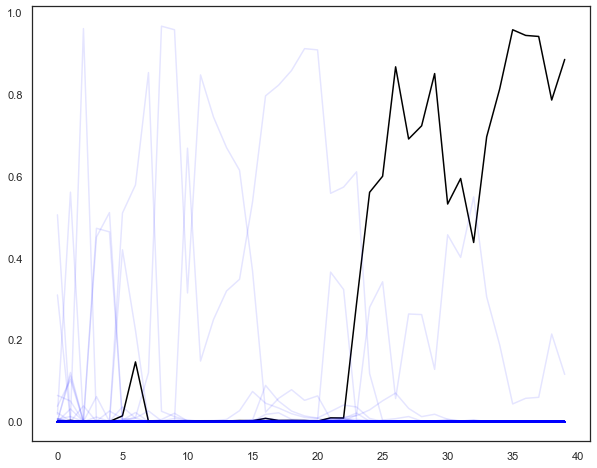

In [610]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, 2000):
    if i == np.where(lb.classes_ == bird)[0][0]:
        ax.plot(probs_stack[:, i], color='black', alpha=1, markersize=5)
    else:
        ax.plot(probs_stack[:, i], color='blue', alpha=0.1)
        
#plt.setp([ax], ylim=(-0.0002, 0.2))

159

In [621]:
WhichBird('hallo', model=model)[195]

2.7409183e-06

In [573]:
birds = df_CUB.Bird.unique()

In [626]:
data_birds = collections.defaultdict(list)


for bird in tqdm_notebook(list(PoS_dict.keys())[0:40]):
    text_span = ''
    
    for row in PoS_dict[bird][0:40]:
    #for row in important_stuff:
        text_span += f' {row}.' 
        probabilities_stacked = WhichBird(text_span, model=model)
        idx = np.where(lb.classes_ == bird)[0][0]
        data_birds[bird].append(probabilities_stacked[idx])

  0%|          | 0/40 [00:00<?, ?it/s]

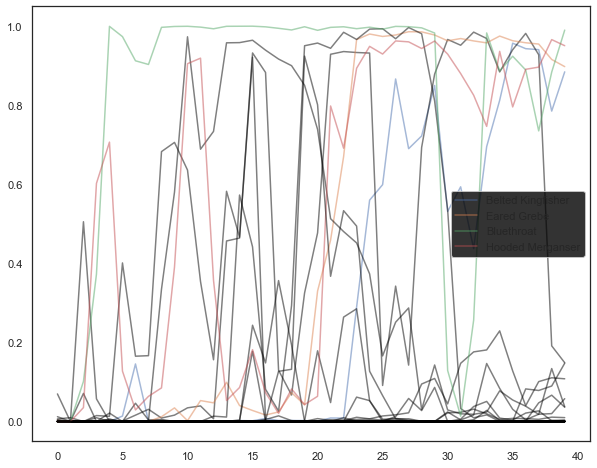

In [633]:
fig, ax = plt.subplots(figsize=(10, 8))

for bird in data_birds.keys():
    if data_birds[bird][-1] > 0.5:
        ax.plot(data_birds[bird], alpha=0.5, label=bird)
    else:
        ax.plot(data_birds[bird], alpha=0.5, color='black')
plt.legend()
plt.show()

In [616]:
data_birds['Belted Kingfisher'].shape

(40, 2000)

In [ ]:
lb.classes_[np.argmax(probs_stack[-1])]

In [ ]:
birds = df_CUB['Bird'].unique()

In [ ]:
data_birds['House Sparrow'].shape

In [ ]:
probs_stack[:, 1]

In [ ]:
np.where(lb.classes_ == bird)[0][0]

In [ ]:
data_birds['House Sparrow'][:, 1]